# Data Science - Laboratorio 4
## Redes neuronales convolucionales (CNN) 
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

## Librerias

NOTA: Importante tener el Token de la API en el folder `C:\Users\<Windows-username>\.kaggle\kaggle.json`

Para mas detalles de otros sistemas dirigirse a: https://github.com/Kaggle/kaggle-api/tree/main/docs#api-credentials

In [1]:
# Kaggle API
import kaggle
from kaggle.rest import ApiException

# Operaciones de archivos
import os
import pickle
import zipfile

# Operaciones de datos
import pandas as pd
import numpy as np

# Operaciones de imágenes
from PIL import Image

# Visualización
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Utilidades
import random
import time

# Pytorch y Torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools


## Carga de Dataset

In [2]:
# Nombre del dataset y rutas
dataset_name = 'agungpambudi/mnist-multiple-dataset-comprehensive-analysis'     # Nombre del dataset
download_path = 'mnist-multiple-dataset-comprehensive-analysis.zip'             # Ruta de descarga
target_dir = 'dataset'                                                            # Directorio de destino

# Verificar si ya existe el directorio de destino
if not os.path.exists(target_dir):
    # Autenticar con la API de Kaggle
    kaggle.api.authenticate()

    try:
        # Descargar el dataset de Kaggle si no existe
        if not os.path.exists(download_path):
            kaggle.api.dataset_download_files(dataset=dataset_name,
                                              quiet=False, 
                                              unzip=False)
            print(f"EXITO: Dataset descargado como '{download_path}'.\n")

    # Manejo de errores
    except ApiException as e:
        print("ERROR al llamar a KaggleApi -> datasets_download: %s\n" % e)

    try:
        # Descomprimir únicamente la carpeta MMNIST
        with zipfile.ZipFile(download_path, 'r') as zip_ref:
            members = [m for m in zip_ref.namelist() if m.startswith('PolyMNIST/MMNIST/')]
            
            # Barra de progreso para la descompresión
            for member in tqdm(members, desc="Descomprimiendo archivos", unit=" archivo"):
                # Obtener el nombre del archivo relativo a MMNIST
                filename = os.path.relpath(member, 'PolyMNIST/MMNIST/')
                target_path = os.path.join(target_dir, filename)
                
                if not member.endswith('/'):
                    # Crear el directorio de destino si no existe
                    os.makedirs(os.path.dirname(target_path), exist_ok=True)
                    # Extraer el archivo
                    with zip_ref.open(member) as source, open(target_path, 'wb') as target:
                        target.write(source.read())

        # Eliminar el archivo ZIP después de la extracción
        os.remove(download_path)
        print(f"\nEXITO: Archivos de PolyMNIST descomprimidos en '{target_dir}'")

    except Exception as e:
        print("ERROR al descomprimir el dataset: %s\n" % e)

else:
    # Si ya existe el directorio, no hacer nada
    print(f"Carpeta {target_dir} ya existe. Se omite la descarga y la extracción.")

Carpeta dataset ya existe. Se omite la descarga y la extracción.


Se crea una instancia de la API de **Kaggle** y se autentica utilizando las credenciales proporcionadas por el Token generado en Kaggle. Posteriormente, se procede a descargar el conjunto de datos en formato comprimido (zip). Una vez completada la descarga, se extraen y descomprimen únicamente los archivos contenidos en la carpeta `PolyMNIST`, ubicándolos en una carpeta destino denominada **dataset**. Este procedimiento se realiza con el fin de evitar el procesamiento adicional de archivos que no serán relevantes para el laboratorio.

- En caso de que ocurra una excepción o error durante la descarga o la descompresión de archivos, se mostrará el mensaje de error correspondiente.
- Para evitar la repetición de la descarga y descompresión en cada ejecución del cuaderno, se verifica la existencia de la carpeta dataset. Si esta carpeta ya está presente, se asume que el proceso se ha completado satisfactoriamente en ejecuciones previas y se omite el proceso en futuras ejecuciones.

## Análisis Exploratorio

### Muestreo de Digitos

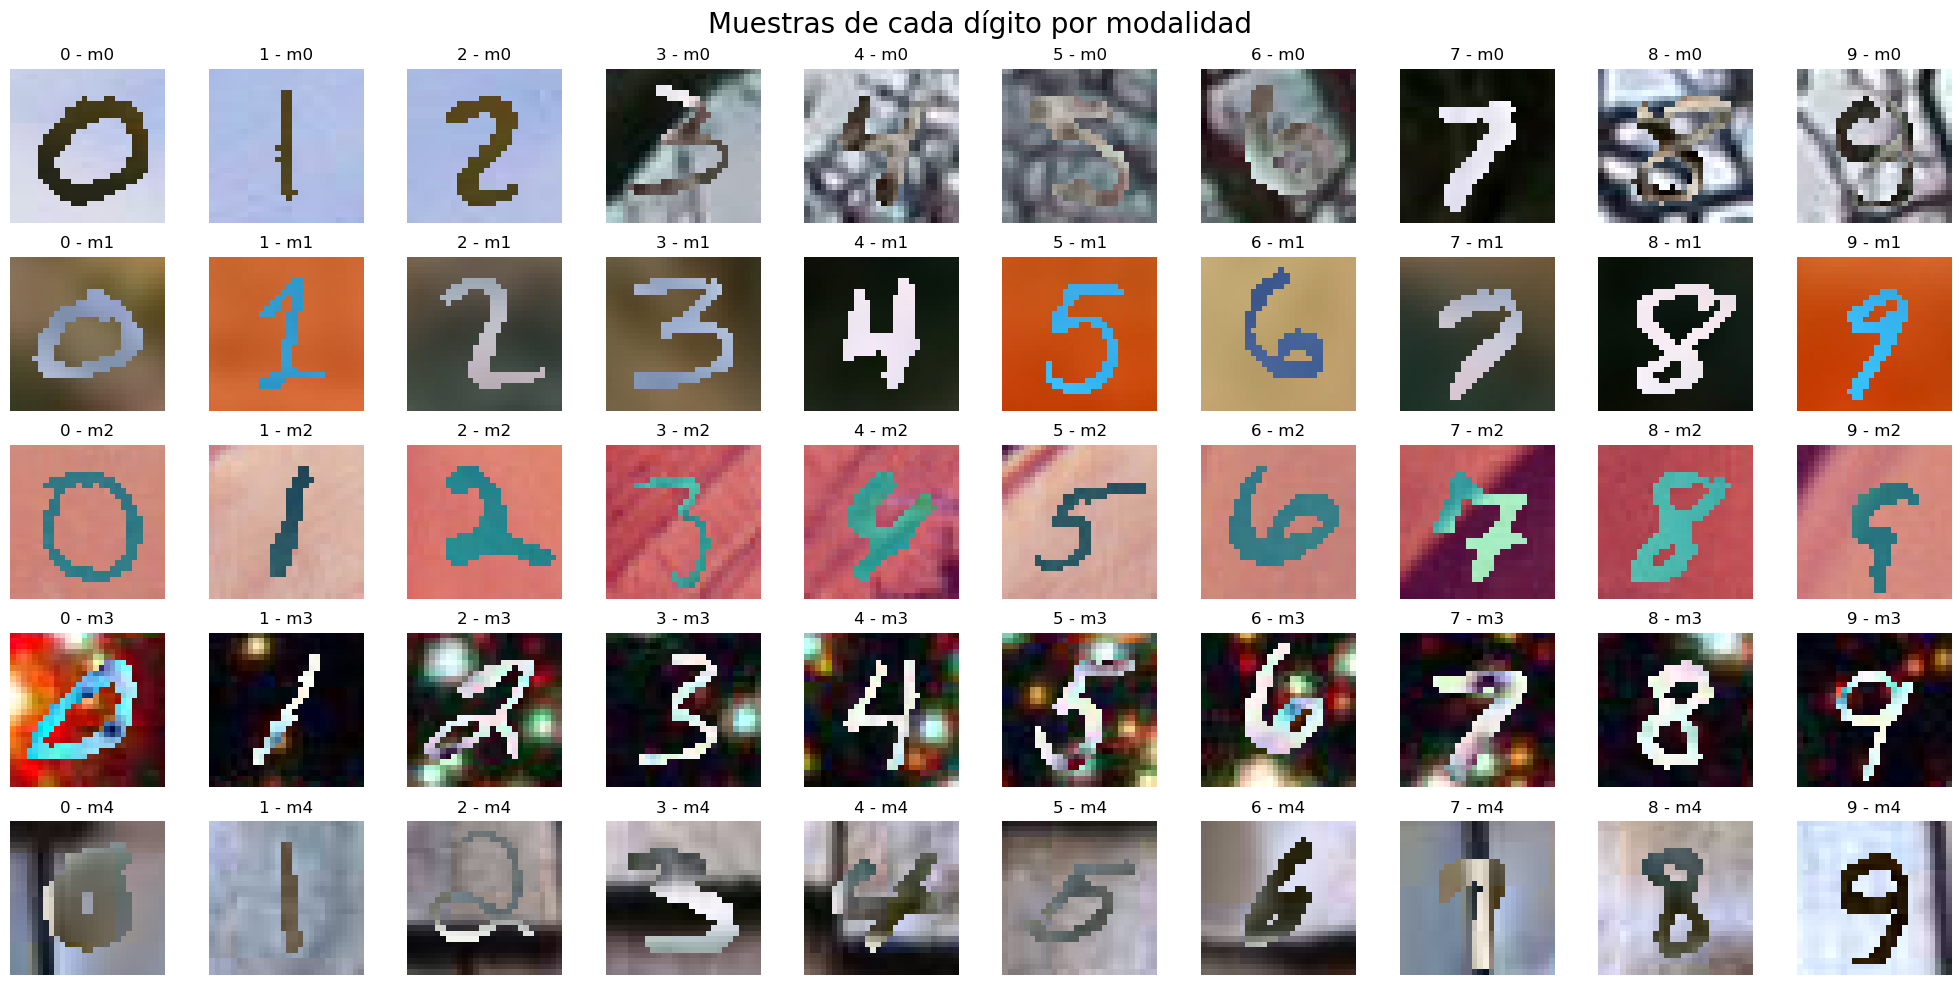

In [3]:
# Definir ruta del conjunto de entrenamiento
dataset_path = 'dataset/train'

# Modaliades de MMNIST
modalities = ['m0', 'm1', 'm2', 'm3', 'm4']

# Diccionario para almacenar muestras por modalidad
samples = {modality: {} for modality in modalities}

# Recorrer las modalidades
for modality in modalities:
    modality_path = os.path.join(dataset_path, modality)
    digits_sampled = set()
    
    # Recorrer las imágenes en la modalidad
    for img_name in os.listdir(modality_path):
        digit = img_name.split('.')[1]  # extraer el dígito
        
        # Si el dígito no ha sido muestreado, almacenar la imagen
        if digit not in digits_sampled:
            img_path = os.path.join(modality_path, img_name)
            image = Image.open(img_path)
            samples[modality][digit] = image
            digits_sampled.add(digit)

# Mostrar las imágenes muestreadas
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.flatten()

for i, modality in enumerate(modalities):
    for j, digit in enumerate(sorted(samples[modality].keys())):
        axes[i*10 + j].imshow(samples[modality][digit], cmap='gray')
        axes[i*10 + j].set_title(f'{digit} - {modality}')
        axes[i*10 + j].axis('off')

plt.suptitle('Muestras de cada dígito por modalidad', fontsize=20)
plt.tight_layout()
plt.show()

Al examinar las imágenes de dígitos en cada modalidad (específicamente para el conjunto de datos de entrenamiento), se observa que los dígitos están superpuestos sobre diversos fondos similares para cada modalidad. Esto confirma que cada modalidad está compuesta por parches aleatorios recortados de una imagen más grande, en la que el dígito está colocado en el centro. La muestra sugiere que los dígitos se colocan en el centro de la imagen y que estas imágenes tienen una relación de aspecto **1:1** (cuadradas).

### Distribuciones de Imágenes

In [4]:
def count_images_by_digit_and_mode(dataset_path):
    """
    Contar el número de imágenes por dígito y modo (entrenamiento o prueba).

    Args:
        dataset_path (str): Ruta del conjunto de datos.

    Returns:
        pd.DataFrame: DataFrame con el conteo de imágenes por dígito y modo.
    """
    data = []
    
    for mode in ['train', 'test']:
        mode_path = os.path.join(dataset_path, mode)
        for modality in modalities:
            modality_path = os.path.join(mode_path, modality)
            for img_name in os.listdir(modality_path):
                digit = img_name.split('.')[1]
                data.append((mode, modality, digit))
    
    df = pd.DataFrame(data, columns=['mode', 'modality', 'digit'])
    return df

#### Distribución de imágenes por modalidad

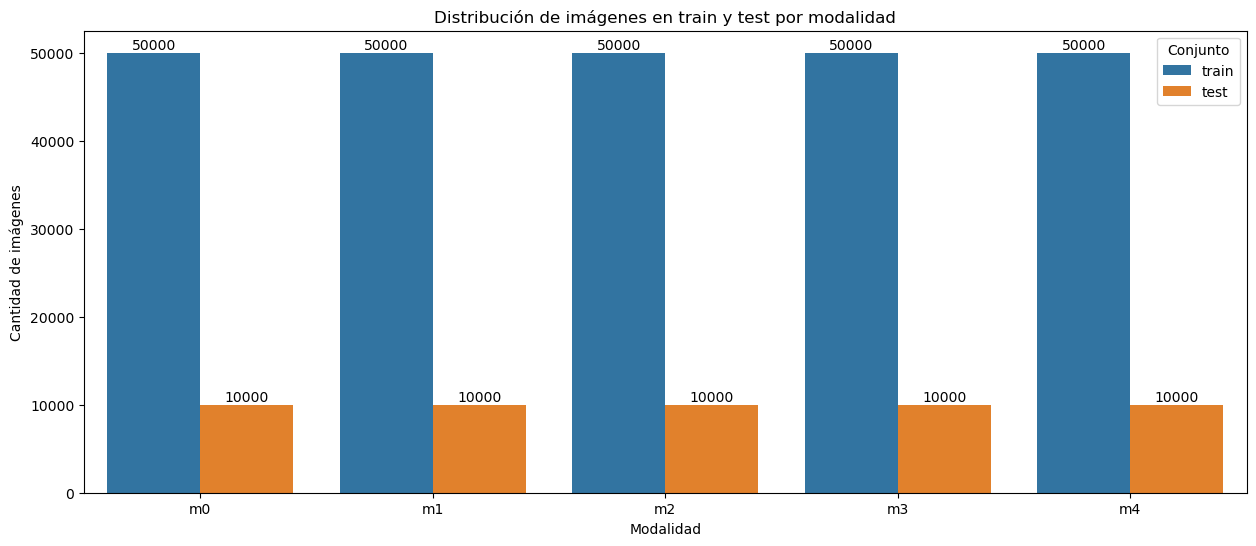

In [5]:
# Contar las imágenes por dígito y modalidad
df_counts = count_images_by_digit_and_mode('dataset')

# Graficar la distribución de imágenes en train y test por modalidad
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df_counts, x='modality', hue='mode')

# Etiquetas en las barras con la cantidad de imágenes
for container in ax.containers:
    ax.bar_label(container)

# Configuración de la gráfica
plt.title('Distribución de imágenes en train y test por modalidad')
plt.legend(title='Conjunto')
plt.xlabel('Modalidad')
plt.ylabel('Cantidad de imágenes')
plt.show()

El gráfico presentado indica que tanto el conjunto de entrenamiento como el de prueba contienen una cantidad uniforme de imágenes en cada modalidad, lo que sugiere un equilibrio en términos de número total de imágenes. Sin embargo, es necesario verificar el equilibrio en la representación de los dígitos. La falta de balance en la representación de los dígitos podría introducir un sesgo hacia aquellos dígitos con una mayor cantidad de representaciones.

#### Distribución de imágenes por dígitos

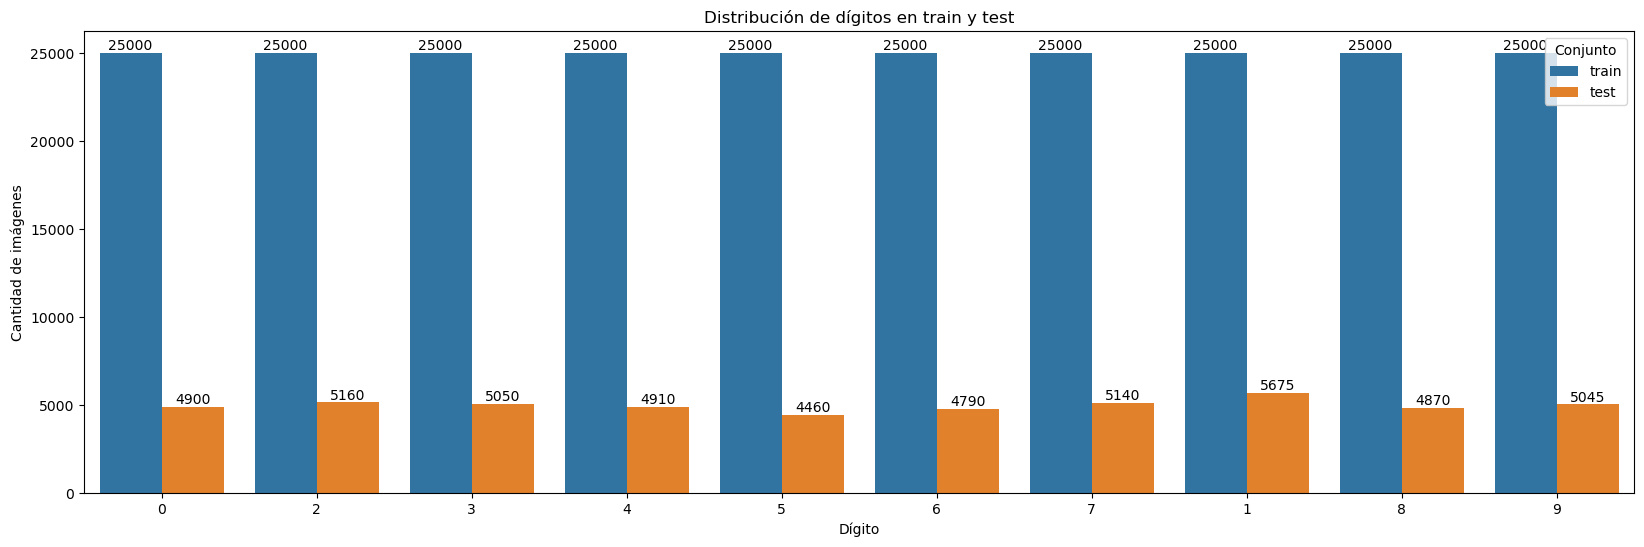

In [6]:
# Graficar la distribución de dígitos en general en train y test
plt.figure(figsize=(20, 6))
ax = sns.countplot(data=df_counts, x='digit', hue='mode')

# Etiquetas en las barras con la cantidad de imágenes
for container in ax.containers:
    ax.bar_label(container)

# Configuración de la gráfica
plt.title('Distribución de dígitos en train y test')
plt.legend(title='Conjunto', loc='upper right')
plt.xlabel('Dígito')
plt.ylabel('Cantidad de imágenes')
plt.show()

Como se anticipaba en la etapa anterior, se ha confirmado que no todos los dígitos tienen una representación equitativa. Los dígitos `1` y `7` presentan una mayor representación, mientras que el dígito `5` tiene una menor representación. El reso de dígitos se encuentran en un rango de **29,000-30,000** imágenes. Esto sugiere la necesidad de aplicar una técnica de balanceo de clases para asegurar una representación uniforme de todos los dígitos en el conjunto de entrenamiento. El equilibrio de clases en el conjunto de prueba no es crítico, ya que estos datos no influyen directamente en el entrenamiento del modelo.

Existen tres estrategias para el balanceo de clases:
- **Oversampling**: Consiste en duplicar las imágenes de los dígitos menos representados para alcanzar el equilibrio de clases, aunque esto podría introducir sesgos hacia las imágenes duplicadas.
- **Undersampling**: Implica eliminar imágenes de los dígitos sobre-representados para lograr el equilibrio, siendo esta estrategia más adecuada cuando se dispone de una gran cantidad de datos.
- **Data Augmentation**: Aplicación de transformaciones a las imágenes para generar nuevas muestras y completar las clases menos representadas, sin pérdida ni duplicación de información, lo que la convierte en una opción ideal.

Para determinar la estrategia más efectiva, es necesario evaluar el balance de clases en cada modalidad por separado, permitiendo así un análisis más detallado de las variaciones en la representación de dígitos en cada modalidad y seleccionar la estrategia más adecuada.

#### Distribución de dígitos por modalidad

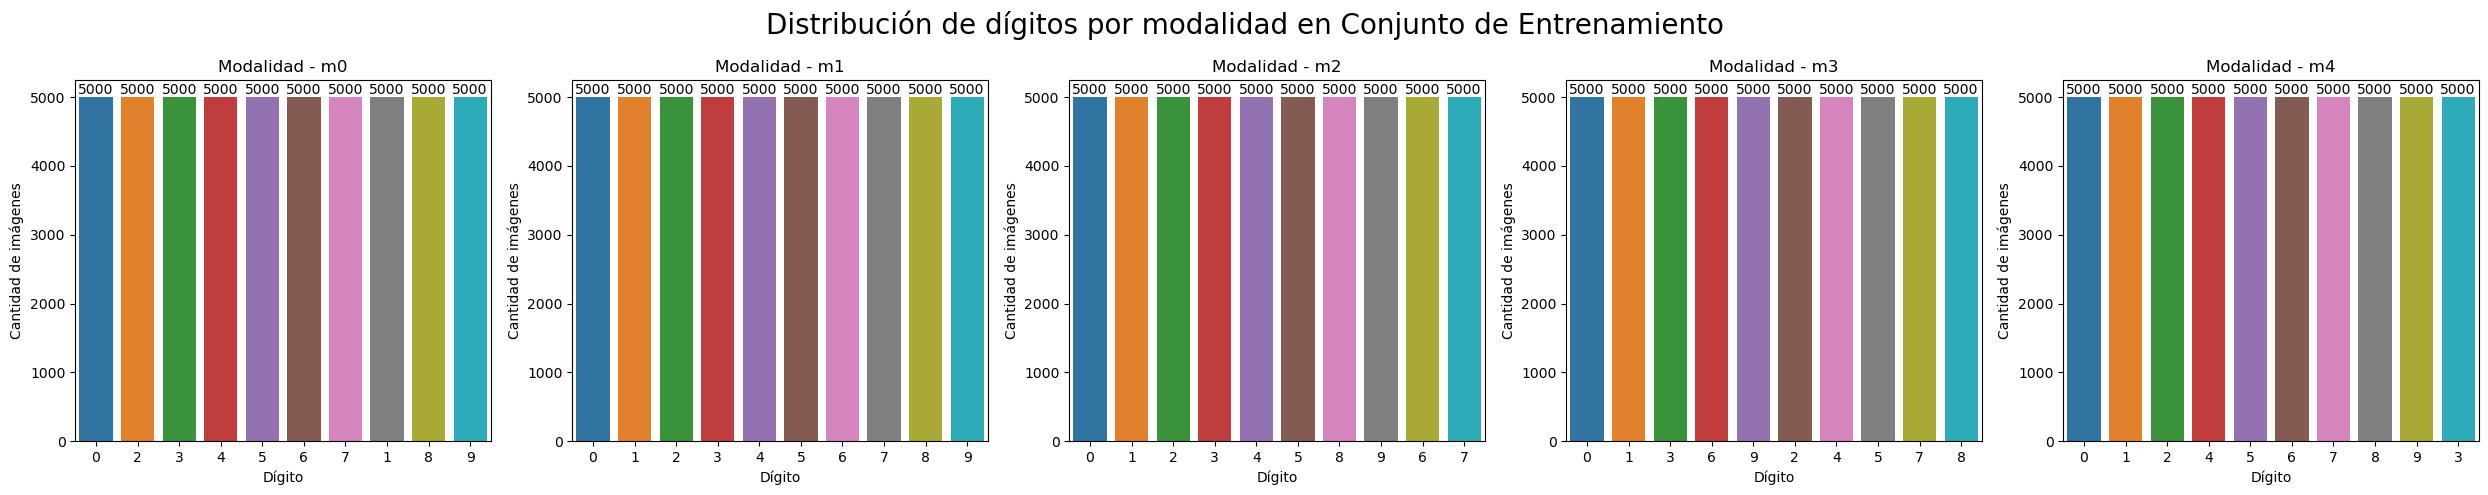

In [7]:
# Graficar la distribución de dígitos por modalidad en el set de entrenamiento
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Recorrer las modalidades
for i, modality in enumerate(modalities):
    # Graficar la distribución de dígitos en entrenamiento por modalidad
    ax = sns.countplot(data=df_counts[(df_counts['modality'] == modality) & (df_counts['mode'] == 'train')],
                  x='digit', ax=axes[i], hue='digit')
    
    # Etiquetas en las barras con la cantidad de imágenes
    for container in ax.containers:
        ax.bar_label(container)
    
    # Configuración de la gráfica
    axes[i].set_title(f'Modalidad - {modality}')
    axes[i].set_ylabel('Cantidad de imágenes')
    axes[i].set_xlabel('Dígito')

# Configuración de la gráfica general
plt.suptitle('Distribución de dígitos por modalidad en Conjunto de Entrenamiento', fontsize=20)
plt.tight_layout()
plt.show()

Con un análisis más detallado, se observa que cada modalidad presenta un conteo uniforme de dígitos, pero con un desequilibrio en la representación. En todos los casos, el dígito `1` es el más representado con más de **6,700** imágenes, seguido por el dígito `7` con más de **6,200** imágenes. El dígito `5` es el menos representado en todos los casos con **5,400** imágenes. El dígito `3` es el tercer dígito más representado, con un conteo de **6,100** imágenes. Los restantes dígitos tienen valores cercanos a **5,800-5,900** imágenes.

#### Resolución de Imágenes y Relación Aspecto

In [8]:
def get_image_size(dataset_path):
    """
    Obtener las dimensiones de las imágenes en el conjunto de datos.
    
    Args:
        dataset_path (str): Ruta del conjunto de datos.
    
    Returns:
        dict: Diccionario con las dimensiones de las imágenes por modalidad y modo.
    """
    image_shapes = {}  # Diccionario para almacenar las dimensiones de las imágenes
    
    # Recorrer los set de datos y modalidades
    for mode in ['train', 'test']:
        # Generar la ruta del set de datos
        mode_path = os.path.join(dataset_path, mode)

        # Recorrer las modalidades
        for modality in modalities:
            # Generar la ruta de la modalidad y obtener las imágenes
            modality_path = os.path.join(mode_path, modality)
            image_files = os.listdir(modality_path)

            # Recorrer las imágenes
            for img_name in tqdm(image_files, desc=f'Obteniendo dimensiones de {modality} en {mode}', unit=' imagen'):
                img_path = os.path.join(modality_path, img_name)
                
                # Abrir la imagen y obtener sus dimensiones
                with Image.open(img_path) as img:
                    width, height = img.size
                    # Almacenar las dimensiones en el diccionario
                    if (mode, modality) not in image_shapes:
                        image_shapes[(mode, modality)] = []
                    image_shapes[(mode, modality)].append((width, height))
    
    # Retornar las dimensiones de las imágenes
    return image_shapes

In [9]:
def save_image_shapes(image_shapes, data_path):
    """
    Guardar las dimensiones de las imágenes en un archivo pickle.

    Args:
        image_shapes (dict): Diccionario con las dimensiones de las imágenes.
        data_path (str): Ruta donde se guardará el archivo pickle.
    
    Returns:
        None
    """
    with open(data_path, 'wb') as f:
        pickle.dump(image_shapes, f)


def load_image_shapes(data_path):
    """
    Cargar las dimensiones de las imágenes desde un archivo pickle.

    Args:
        data_path (str): Ruta del archivo pickle.
    
    Returns:
        dict: Diccionario con las dimensiones de las imágenes.
    """
    with open(data_path, 'rb') as f:
        return pickle.load(f)

In [10]:
image_shapes_path = 'data/image_shapes.pkl'
# Revisar si ya se ha procesado la información de las imágenes
if os.path.exists(image_shapes_path):
    try:
        print("Cargando las dimensiones de las imágenes desde archivo...")
        image_shapes = load_image_shapes(image_shapes_path)
        print("\nEXITO: Dimensiones de las imágenes cargadas.")
    except Exception as e:
        print(f"ERROR al cargar las dimensiones de las imágenes desde archivo: {e}")
else:
    print("Procesando las dimensiones de las imágenes...")
    try:
        image_shapes = get_image_size('dataset')
        print("\nEXITO: Dimensiones de las imágenes procesadas.")
        
        # Guardar las dimensiones de las imágenes
        os.makedirs(os.path.dirname(image_shapes_path), exist_ok=True)
        save_image_shapes(image_shapes, image_shapes_path)
        print("\nEXITO: Dimensiones de las imágenes guardadas en archivo.")
    except Exception as e:
        print(f"\nERROR al procesar las dimensiones de las imágenes: {e}")

Cargando las dimensiones de las imágenes desde archivo...

EXITO: Dimensiones de las imágenes cargadas.


Para evitar tener que obtener las dimensiones de todas las imágenes dentro del conjunto de datos, se crea un archivo `pickle`. De esta manera al ejecutar nuevamente el notebook solo se carga la información guardada en el archivo en lugar de abrir y obtener las dimensiones de cada imágen.

In [11]:
# Mostrar las dimensiones de las imágenes por modalidad y conjunto
for (mode, modality), shapes in image_shapes.items():
    print(f"Dimensiones de imágenes con {modality} en {mode}:")
    size_counts = {}
    for width, height in shapes:
        size = (width, height)
        if size not in size_counts:
            size_counts[size] = 0
        size_counts[size] += 1
    
    for size, count in size_counts.items():
        print(f"\tResolución {size[0]}x{size[1]}: {count} imágenes")
    print()

Dimensiones de imágenes con m0 en train:
	Resolución 28x28: 60000 imágenes

Dimensiones de imágenes con m1 en train:
	Resolución 28x28: 60000 imágenes

Dimensiones de imágenes con m2 en train:
	Resolución 28x28: 60000 imágenes

Dimensiones de imágenes con m3 en train:
	Resolución 28x28: 60000 imágenes

Dimensiones de imágenes con m4 en train:
	Resolución 28x28: 60000 imágenes

Dimensiones de imágenes con m0 en test:
	Resolución 28x28: 10000 imágenes

Dimensiones de imágenes con m1 en test:
	Resolución 28x28: 10000 imágenes

Dimensiones de imágenes con m2 en test:
	Resolución 28x28: 10000 imágenes

Dimensiones de imágenes con m3 en test:
	Resolución 28x28: 10000 imágenes

Dimensiones de imágenes con m4 en test:
	Resolución 28x28: 10000 imágenes



Esto indica que todas las imágenes en el conjunto de datos tienen una resolución uniforme de 28 x 28 píxeles. Por lo tanto, no es necesario ajustar las dimensiones de las imágenes, ya que son consistentes. Sin embargo, se podría considerar reducir la resolución de las imágenes a 20 x 20 o incluso 10 x 10 para acelerar el proceso de entrenamiento.

## Preprocesamiento

### Balanceo de Clases

Para manejar el desbalance de clases en el conjunto de datos, se ha decidido aplicar **undersampling** al conjunto de datos de entrenamiento. 

Dado que el conjunto de datos cuenta con un número variable de imágenes por dígito y el equipo disponible no es de última generación, el undersampling proporciona una solución más simple y eficiente para equilibrar las clases sin complicar el proceso inicial. 

Se reducirá el número de imágenes a **5,000** por dígito en cada modalidad, resultando en un total de **25,000** imágenes por dígito en el conjunto de entrenamiento. 
A pesar de la reducción en el número total de imágenes mediante undersampling, el conjunto de datos resultante sigue siendo considerablemente grande y representativo. Esto representa más del **80%** del conjunto de datos original, conservando una cantidad significativa de información para el entrenamiento del modelo.

Esto permitirá que el procesamiento sea más manejable y evitará problemas potenciales con duplicados en aplicaciones futuras de data augmentation. 

In [12]:
def undersample_dataset(dataset_path, target_count=5000):
    modalities = ['m0', 'm1', 'm2', 'm3', 'm4']
    digits = [str(i) for i in range(10)]  # Dígitos del 0 al 9

    for modality in modalities:
        print(f"Procesando modalidad: {modality}...")
        for digit in digits:
            digit_path = os.path.join(dataset_path, modality)
            image_files = [f for f in os.listdir(digit_path) if f.split('.')[1] == digit]
            
            if len(image_files) > target_count:
                print(f"Submuestreando dígito {digit}: {len(image_files)} -> {target_count}")
                random.shuffle(image_files)
                files_to_remove = image_files[target_count:]  # Archivos a eliminar
                
                # Usar tqdm para mostrar la barra de progreso mientras eliminamos archivos
                for file in tqdm(files_to_remove, desc=f'Removing excess {digit}', unit=' imagen'):
                    os.remove(os.path.join(digit_path, file))
            else:
                print(f"Omitiendo dígito '{digit}' (no se requiere undersampling).")

        print(f"Modalidad {modality} procesada.\n")

In [13]:
# Ejecutar el undersampling
undersample_dataset('dataset/train')

Procesando modalidad: m0...
Omitiendo dígito '0' (no se requiere undersampling).
Omitiendo dígito '1' (no se requiere undersampling).
Omitiendo dígito '2' (no se requiere undersampling).
Omitiendo dígito '3' (no se requiere undersampling).
Omitiendo dígito '4' (no se requiere undersampling).
Omitiendo dígito '5' (no se requiere undersampling).
Omitiendo dígito '6' (no se requiere undersampling).
Omitiendo dígito '7' (no se requiere undersampling).
Omitiendo dígito '8' (no se requiere undersampling).
Omitiendo dígito '9' (no se requiere undersampling).
Modalidad m0 procesada.

Procesando modalidad: m1...
Omitiendo dígito '0' (no se requiere undersampling).
Omitiendo dígito '1' (no se requiere undersampling).
Omitiendo dígito '2' (no se requiere undersampling).
Omitiendo dígito '3' (no se requiere undersampling).
Omitiendo dígito '4' (no se requiere undersampling).
Omitiendo dígito '5' (no se requiere undersampling).
Omitiendo dígito '6' (no se requiere undersampling).
Omitiendo dígito '

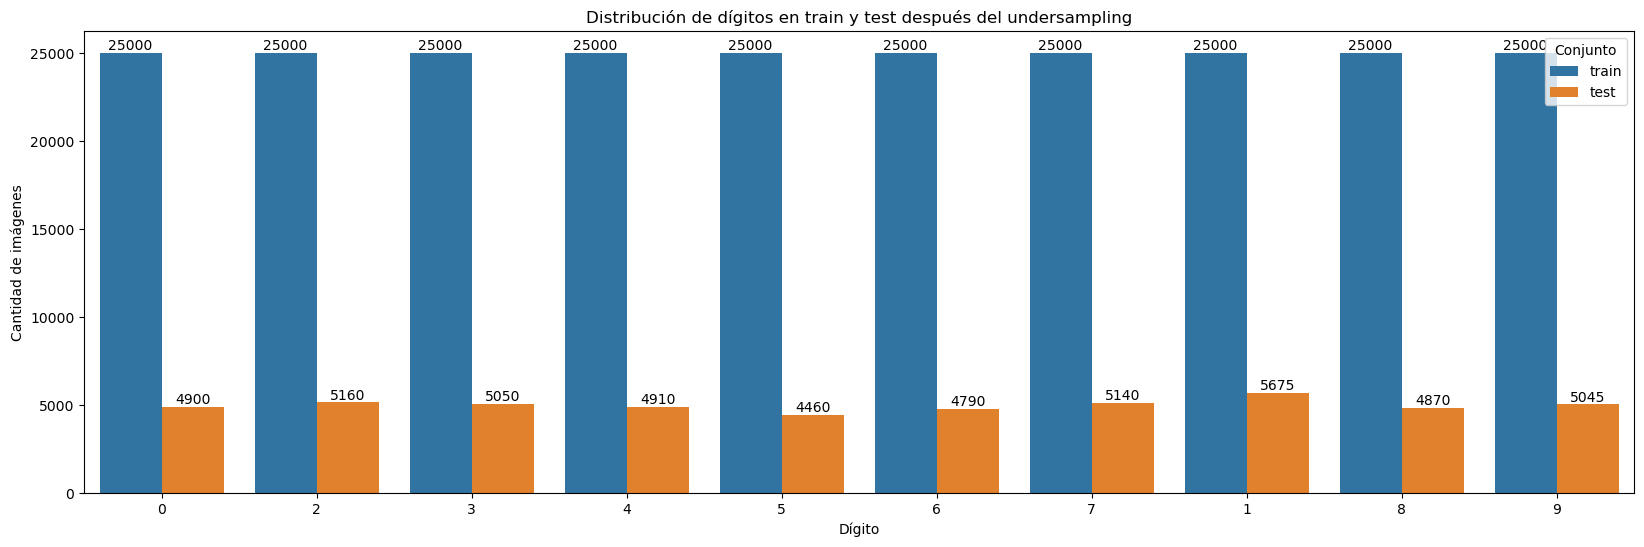

In [14]:
# Contar las imágenes por dígito y modalidad
df_counts = count_images_by_digit_and_mode('dataset')

# Graficar la distribución de dígitos en general en train y test
plt.figure(figsize=(20, 6))
ax = sns.countplot(data=df_counts, x='digit', hue='mode')

# Etiquetas en las barras con la cantidad de imágenes
for container in ax.containers:
    ax.bar_label(container)

# Configuración de la gráfica
plt.title('Distribución de dígitos en train y test después del undersampling')
plt.legend(title='Conjunto', loc='upper right')
plt.xlabel('Dígito')
plt.ylabel('Cantidad de imágenes')
plt.show()

Con esta ejecucion ahora todos los digitos en el conjunto de entrenamiento estan balanceados. Se ignora el conjunto de pruebas pues los proximos modelos no se basaran en esos datos para aprender a clasificar digitos.

### Escalado de imágenes

Se considera la posibilidad de reducir la resolución de las imágenes de dígitos del tamaño original de `28x28` a dimensiones más pequeñas de `25x25`, `20x20`, `15x15` y `10x10` píxeles. El objetivo de este experimento es evaluar cuánta información relevante se pierde en el proceso de escalado, especialmente para dígitos que son visualmente similares y pueden confundirse fácilmente. 

Antes de aplicar cualquier cambio a todo el conjunto de datos, se realizarán pruebas selectivas utilizando muestras aleatorias de imágenes para los dígitos **8**, **3**, **7** y **1** para la modalidad m0. 

De esta manera, sera posible observar el impacto del escalado en la legibilidad y distinción de características críticas antes de tomar una decisión sobre la resolución óptima para el entrenamiento.

In [15]:
def load_and_resize_image(image_path, new_size):
    """
    Cargar una imagen y redimensionarla.

    Args:
        image_path (str): Ruta de la imagen.
        new_size (tuple): Nueva dimensión de la imagen.
    
    Returns:
        PIL.Image: Imagen redimensionada.
    """
    # Cargar la imagen
    image = Image.open(image_path)

    # Redimensionar la imagen con interpolación bicúbica
    resized_image = image.resize(size=new_size, 
                        resample=Image.Resampling.LANCZOS)
    
    return resized_image

In [16]:
def find_random_images(base_path, digits, num_images=1):
    """
    Encontrar imágenes aleatorias de los dígitos especificados en la ruta base.

    Args:
        base_path (str): Ruta base de las imágenes.
        digits (list): Lista de dígitos a buscar.
        num_images (int): Número de imágenes a seleccionar por dígito.
    
    Returns:
        list: Lista de rutas de las imágenes seleccionadas.
    """
    image_paths = []
    # Recorrer los dígitos
    for digit in digits:
        # Encontrar las imágenes del dígito
        digit_paths = [os.path.join(base_path, f) for f in os.listdir(base_path) if f.endswith(f'.{digit}.png')]
        
        # Seleccionar imágenes aleatorias
        selected_images = random.sample(digit_paths, num_images)

        # Agregar las rutas de las imágenes seleccionadas
        image_paths.extend(selected_images)
        
    return image_paths

In [17]:
def compare_resolutions(image_paths, sizes):
    """
    Comparar las resoluciones de las imágenes redimensionadas.

    Args:
        image_paths (list): Lista de rutas de las imágenes.
        sizes (list): Lista de tamaños de redimensionamiento.

    Returns:
        None
    """
    fig, axes = plt.subplots(len(image_paths), len(sizes), figsize=(20, len(image_paths) * 3))
    
    for i, image_path in enumerate(image_paths):
        original_image = Image.open(image_path)
        for j, size in enumerate(sizes):
            resized_image = load_and_resize_image(image_path, size)
            digit = image_path.split('.')[-2]
            ax = axes[i, j] if len(image_paths) > 1 else axes[j]
            ax.imshow(np.array(resized_image))
            ax.set_title(f'Digito {digit} - Dimension: {size[0]}x{size[1]}')
            ax.axis('off')

    plt.suptitle('Comparación de resoluciones de imágenes', fontsize=20)
    plt.tight_layout()
    plt.show()

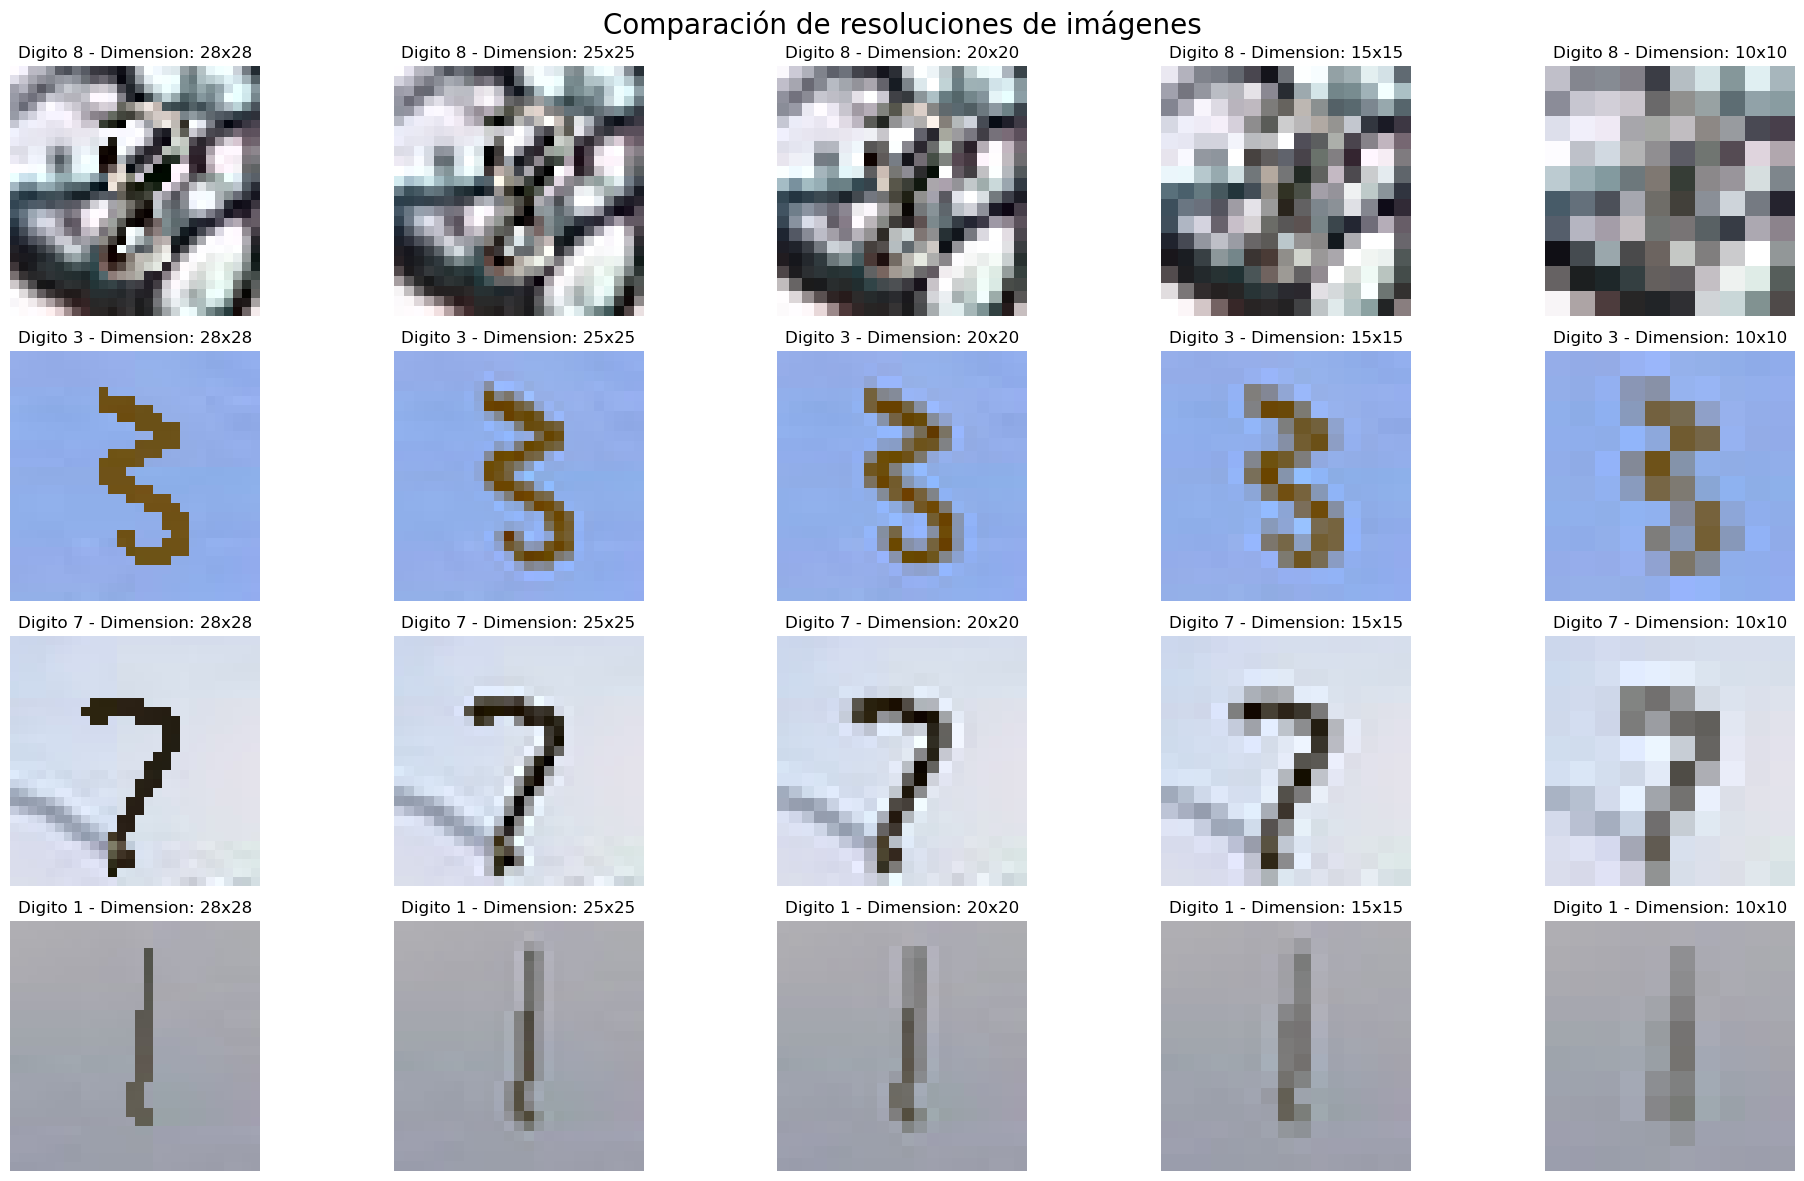

In [18]:
# Ruta al directorio de entrenamiento de la modalidad 1
train_dataset_path = 'dataset/train/m0'

# Dígitos específicos que queremos comparar
digits_of_interest = ['8', '3', '7', '1']

# Encuentra imágenes aleatorias para cada dígito especificado
image_paths = find_random_images(train_dataset_path, digits_of_interest, num_images=1)

sizes = [(28, 28), (25, 25), (20, 20), (15,15), (10, 10)]
# Compara las resoluciones de las imágenes
compare_resolutions(image_paths, sizes)

Los resultados de las pruebas de escalado mostraron que, aunque en hay casos donde la información se conserva de manera relativamente satisfactoria, existen situaciones específicas donde incluso en la resolución original era difícil distinguir claramente el dígito. Al reducir aún más la resolución, estos dígitos se volvieron prácticamente indistinguibles del fondo, perdiendo detalles cruciales que son esenciales para un reconocimiento preciso asi como un suaviazado de los bordes de los trazos. Dada la importancia de mantener una alta precisión y minimizar la confusión entre dígitos similares en nuestro modelo, se decidio no escalar las imágenes. 

### Guardado del dataset como CSV

In [19]:
def image_to_row(image_path, label):
    image = Image.open(image_path).convert('L')  # Convertir a escala de grises
    image_array = np.array(image).flatten()  # Aplanar la matriz de la imagen a una fila
    return [label] + image_array.tolist()

In [20]:
def process_dataset(folder, output_csv):
    data = []
    
    # Calcular el número total de imágenes para la barra de progreso
    total_images = sum(len(files) for _, _, files in os.walk(folder))
    
    with tqdm(total=total_images, desc=f"Procesando {folder}", unit=" imagen") as pbar:
        for mode in ['m0', 'm1', 'm2', 'm3', 'm4']:
            mode_path = os.path.join(folder, mode)
            for filename in os.listdir(mode_path):
                if filename.endswith('.png'):
                    label = int(filename.split('.')[1])  # Obtener el dígito de la imagen
                    file_path = os.path.join(mode_path, filename)
                    data.append(image_to_row(file_path, label))
                    pbar.update(1)  # Actualizar la barra de progreso
    
    # Crear un DataFrame y guardar en CSV
    print("\nGenerando columnas de dataframe...")
    columns = ['label'] + [f'pixel{i}' for i in range(784)]
    
    print("\nGenerando DataFrame...")
    df = pd.DataFrame(data, columns=columns, dtype=np.float32)
    
    df.to_csv(output_csv, index=False)
    print(f"\nEXITO: DataFrame generado y guardado en '{output_csv}'.")
    return df

In [21]:
if not os.path.exists('data/train.csv'):
    train_df = process_dataset('dataset/train', 'data/train.csv')
else:
    print("Archivo 'train.csv' ya existe. Se omite el procesamiento.")
    train_df = pd.read_csv('data/train.csv', dtype=np.float32)

Archivo 'train.csv' ya existe. Se omite el procesamiento.


In [22]:
if not os.path.exists('data/test.csv'):
    test_df = process_dataset('dataset/test', 'data/test.csv')
else:
    print("Archivo 'test.csv' ya existe. Se omite el procesamiento.")
    test_df = pd.read_csv('data/test.csv', dtype=np.float32)

Archivo 'test.csv' ya existe. Se omite el procesamiento.


## Redes Neuronales Convolucionales

### Preparación de Datos

In [23]:
def preprocessing(train, test, split_train_size = 0.2):
    
    # Dividir el conjunto de entrenamiento en características y etiquetas
    targets = train.label.values
    features = train.drop(["label"], axis = 1).values
    
    # Normalizar las características
    features = features/255.
    X_test = test.values/255.
    
    # Generar un conjunto de validación a partir del conjunto de entrenamiento 
    # para evaluar el rendimiento del modelo 
    X_train, X_val, y_train, y_val = train_test_split(features,
                                                      targets,
                                                      test_size = split_train_size,
                                                      random_state = 42) 
    
    # Convertir los conjuntos de datos de entrenamiento a tensores de PyTorch
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor)

    # Convertir los conjuntos de datos de validación a tensores de PyTorch
    X_val = torch.from_numpy(X_val)
    y_val = torch.from_numpy(y_val).type(torch.LongTensor) # data type is long
    
    # Convertir el conjunto de datos de prueba a tensores de PyTorch
    X_test = torch.from_numpy(X_test)

    print(f'Dimensiones de los datos de entrenamiento: {X_train.shape}')
    print(f'\nDimensiones de las etiquetas de entrenamiento: {y_train.shape}')
    print(f'\nDimensiones de los datos de validación: {X_val.shape}')
    print(f'\nDimensiones de las etiquetas de validación: {y_val.shape}')
    print(f'\nDimensiones de los datos de prueba: {X_test.shape}')
    
    return X_train, y_train, X_val, y_val, X_test

### Preparación de Data Loaders

In [24]:
def get_data_loaders(X_train, y_train, X_val, y_val, X_test, batch_size):
    # Crear conjuntos de datos con tensores de PyTorch
    train_tensor = torch.utils.data.TensorDataset(X_train, y_train)
    val_tensor = torch.utils.data.TensorDataset(X_val, y_val)
    test_tensor = torch.utils.data.TensorDataset(X_test)

    # Crear dataloaders para el conjunto de entrenamiento, validación y prueba
    train_loader = torch.utils.data.DataLoader(train_tensor, 
                                            batch_size = batch_size,
                                            shuffle = True)

    val_loader = torch.utils.data.DataLoader(val_tensor, 
                                            batch_size = batch_size, 
                                            shuffle = False)

    test_loader = torch.utils.data.DataLoader(test_tensor, 
                                            batch_size = batch_size,
                                            shuffle = False)
    
    return train_loader, val_loader, test_loader

### Creacion de la CNN

In [25]:
# Configuración de ruda de CUDA
os.environ['CUDA_PATH'] = r"C:/Program Files/NVIDIA GPU Computing Toolkit//CUDA//v12.4"  # Ruta para CUDA 12.4

In [26]:
def instantiate_model(model_class):
    # Instanciar el modelo CNN 
    model = model_class()

    # Optimizador Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

    # Función de pérdida de entropía cruzada 
    criterion = nn.CrossEntropyLoss()

    # Scheduler para reducir la tasa de aprendizaje
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    # Verificando si CUDA (GPU) está disponible
    if torch.cuda.is_available():
        print(f"CUDA DISPONIBLE: si")
        gpu_name = torch.cuda.get_device_name(torch.cuda.current_device())
        print(f"El modelo se entrenara con GPU: \n\t{gpu_name}")
        model = model.cuda()
        criterion = criterion.cuda()
    else:
        print(f"CUDA DISPONIBLE: no")
        print("El modelo se entrenara con CPU")

    return model, optimizer, criterion, exp_lr_scheduler

### Entrenamiento

In [27]:
def fit(model, train_loader, criterion, optimizer, exp_lr_scheduler, batch_size):

    # Establecer el modelo en modo de entrenamiento    
    model.train()
    
    # Inicializar la pérdida y la precisión de entrenamiento
    train_running_loss = 0.0
    train_running_correct = 0

    # Iterar sobre el conjunto de entrenamiento
    for data, target in train_loader:
        data, target = Variable(data.view(batch_size,1,28,28)), Variable(target)
        
        # Verificar si CUDA está disponible
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        # Reestablecer los gradientes a cero
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # Actualizar los gradientes
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        
        # Backward Propagation y optimización
        loss.backward()
        optimizer.step()
            
    # Actualizar el parámetro lr
    exp_lr_scheduler.step()
            
    # Calcular la pérdida y la precisión de entrenamiento
    train_loss = train_running_loss/len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_loader.dataset)    
    
    return train_loss, train_accuracy

### Validacion

In [28]:
def validate(model, data_loader, batch_size, criterion):
    
    # Establecer el modelo en modo de validación
    model.eval()
    val_preds = torch.LongTensor().cuda()
    val_proba = torch.LongTensor().cuda()
    
    # Inicializar la pérdida y la precisión de validación
    val_running_loss = 0.0
    val_running_correct = 0
    
    # Iterar sobre el conjunto de validación
    with torch.no_grad():
        for data, target in data_loader:

            # Arreglar las dimensiones de los datos
            data = data.view(batch_size, 1, 28, 28)
            
            # Verificar si CUDA está disponible
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            
            # Calcular la salida y la pérdida
            output = model(data)
            loss = criterion(output, target)
            
            # Actualizar la pérdida de validación 
            # y las predicciones correctas
            val_running_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            proba = torch.nn.functional.softmax(output.data, dim=1)

            # Actualizar la precisión de validación
            val_running_correct += pred.eq(target.data.view_as(pred)).cpu().sum() 
            
            # Almacenar las predicciones de validación con probabilidades para cálculos de matriz de confusión 
            # y los mejores errores cometidos
            val_preds = torch.cat((val_preds, pred), dim=0)
            val_proba = torch.cat((val_proba, proba))

    # Calcular la pérdida y la precisión de validación
    val_loss = val_running_loss/len(data_loader.dataset)
    val_accuracy = 100. * val_running_correct/len(data_loader.dataset) 
    
    return val_loss, val_accuracy, val_preds, val_proba

### Entrenando el modelo

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
def train_validate_model(epochs, model, train_loader, data_loader, criterion, optimizer, exp_lr_scheduler, batch_size):
    # Listas para almacenar la pérdida y la precisión de entrenamiento y validación
    train_loss, train_accuracy = [], []
    val_loss, val_accuracy = [], []
    val_preds, val_proba = [], []

    # Iterar sobre las épocas
    for epoch in range(epochs):
        # Inicializar el tiempo de inicio
        start_time = time.time()
        
        # Entrenar y validar el modelo
        train_epoch_loss, train_epoch_accuracy = fit(model, 
                                                     train_loader, 
                                                     criterion, 
                                                     optimizer, 
                                                     exp_lr_scheduler, 
                                                     batch_size)
        
        val_epoch_loss, val_epoch_accuracy, val_epoch_preds, val_epoch_proba = validate(model, 
                                                                                        data_loader, 
                                                                                        batch_size, 
                                                                                        criterion)
        
        # Detener el tiempo de finalización
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Obtener las predicciones de validación
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        
        # Almacenar la pérdida y la precisión de validación
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        # Almacenar las predicciones y probabilidades de validación
        val_preds.append(val_epoch_preds)
        val_proba.append(val_epoch_proba)
        
        # Imprimir la pérdida y la precisión de entrenamiento y validación
        print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
        print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train Accuracy: {train_epoch_accuracy:.2f}')
        print(f'\t Val. Loss: {val_epoch_loss:.3f} |  Val. Accuracy: {val_epoch_accuracy:.2f}')
    
    return train_loss, train_accuracy, val_loss, val_accuracy, val_preds, val_proba


### Historial de Rendimiento

In [31]:
def plot_history(train_loss, val_loss, train_acc, val_acc, name):
    # Crear un solo plot con dos subplots: uno para accuracy y otro para loss
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Subplot para la precisión
    axes[0].plot(train_acc, label='Train Accuracy')
    axes[0].plot(val_acc, label='Validation Accuracy')
    axes[0].set_title('Precision del Modelo')
    axes[0].set_xlabel('Epoca')
    axes[0].set_ylabel('Precision')
    axes[0].legend(loc='upper left')
    axes[0].grid(True)
    
    # Subplot para la pérdida
    axes[1].plot(train_loss, label='Pérdida de Entrenamiento')
    axes[1].plot(val_loss, label='Pérdida de Validación')
    axes[1].set_title('Pérdida del Modelo')
    axes[1].set_xlabel('Epoca')
    axes[1].set_ylabel('Pérdida')
    axes[1].legend(loc='upper right')
    axes[1].grid(True)
    
    # Configuración general de la figura
    plt.suptitle(f"Historial de Entrenamiento del Modelo - {name}", fontsize=20)
    plt.tight_layout()
    plt.show()

### Predicciones y Evaluacion del Modelo

In [32]:
def plot_confusion_matrix(y_val, val_preds, epochs, name):
    # Obtener las predicciones de validación
    y_pred_classes = val_preds[epochs - 1].cpu().numpy().ravel()

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_val, y_pred_classes)

    # Normalizar la matriz de confusión por filas (por clases reales)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Configurar las etiquetas con conteos y porcentajes por clase
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm_percentage.flatten()]
    box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0], cm.shape[1])
    
    # Graficar la matriz de confusión
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=cm, 
                annot=box_labels, 
                fmt="", 
                linewidths=1, 
                linecolor='black',
                cmap="coolwarm", 
                xticklabels=range(10), 
                yticklabels=range(10))
    
    plt.yticks(rotation=0)
    plt.xlabel('Digitos Predichos')
    plt.ylabel('Digitos Reales')
    plt.title(f"Matriz de Confusión del Modelo - {name}")
    plt.show()

### Muestreo de Predicciones

In [33]:
def plot_predictions_sample(val_preds, y_val, X_val, epochs, name):
    # Definir el tamaño de las predicciones correctas e incorrectas
    correct_size = 9
    wrong_size = 9

    # Obtener las predicciones de validación
    y_pred_classes = val_preds[epochs - 1].cpu().numpy().ravel()

    # Mostrar los errores de clasificación
    errors = (y_pred_classes - y_val.cpu().numpy() != 0)

    # Obtener las clases de los errores
    y_pred_classes_errors = y_pred_classes[errors]
    y_true_errors = y_val[errors]
    X_val_errors = X_val[errors]

    # Crear la figura con 2 subplots (3x3 cada uno) y espacio para la línea divisoria
    fig, axes = plt.subplots(3, 7, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1, 1, 0.1, 1, 1, 1]})
    fig.suptitle(f"Muestreo de Predicciones del Modelo - {name}", fontsize=20)
    
    # Subplot para predicciones correctas (3x3)
    correct_indices = [i for i in range(len(y_val)) if y_val[i] == y_pred_classes[i]]
    random_correct_indices = random.sample(correct_indices, correct_size)
    
    for i, index in enumerate(random_correct_indices):
        ax = axes[i // 3, i % 3]  # Ubicar en las primeras 3 columnas (3x3 subplots)
        ax.imshow(X_val[index].view(28, 28), cmap='gray')
        ax.set_title(f"Predicho: {y_pred_classes[index]}\nReal: {y_val[index]}")
        ax.axis('off')
    
    # Dibujar la línea divisoria en un subplot central reducido
    for j in range(3):
        axes[j, 3].axis('off')  # Desactivar los ejes para las celdas de la línea divisoria
        axes[j, 3].plot([0.5, 0.5], [0, 1], transform=axes[j, 3].transAxes, color='black', linewidth=2)
    
    # Subplot para predicciones erróneas (3x3)
    random_error_indices = random.sample(range(len(y_true_errors)), wrong_size)
    
    for i, index in enumerate(random_error_indices):
        ax = axes[i // 3, 4 + i % 3]  # Ubicar en las últimas 3 columnas (3x3 subplots)
        ax.imshow(X_val_errors[index].view(28, 28), cmap='gray')
        ax.set_title(f"Predicho: {y_pred_classes_errors[index]}\nReal: {y_true_errors[index]}")
        ax.axis('off')
    
    # Título para cada conjunto de subplots
    fig.text(0.20, 0.92, "Predicciones Correctas", ha="center", fontsize=16)
    fig.text(0.80, 0.92, "Predicciones Erróneas", ha="center", fontsize=16)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()

### Modelo 1

#### Hiperparametros

In [34]:
# Definir hiperparámetros
batch_size = 100        # Tamaño del lote
n_iter = 2500           # Número de iteraciones
epochs = 5              # Número de épocas

#### Datasets

In [35]:
X_train, y_train, X_val, y_val, X_test = preprocessing(train_df, 
                                                       test_df)

Dimensiones de los datos de entrenamiento: torch.Size([200000, 784])

Dimensiones de las etiquetas de entrenamiento: torch.Size([200000])

Dimensiones de los datos de validación: torch.Size([50000, 784])

Dimensiones de las etiquetas de validación: torch.Size([50000])

Dimensiones de los datos de prueba: torch.Size([50000, 785])


#### Dataloaders

In [36]:
train_loader, val_loader, test_loader = get_data_loaders(X_train, 
                                                         y_train, 
                                                         X_val, 
                                                         y_val, 
                                                         X_test, 
                                                         batch_size)

#### Definicion de Arquitectura

In [37]:
class CNN_Model1(nn.Module):
    def __init__(self):
        super(CNN_Model1, self).__init__()
        
        # Capa de convolución 1
        self.c1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Capa de Max pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        # Capa de dropout 1
        self.dropout1 = nn.Dropout(0.25)
        
        # Capa de convolución 2
        self.c2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Capa de Max pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))

        # Capa de dropout 2
        self.dropout2 = nn.Dropout(0.25)
        
        # Capa lineal 1
        self.fc1 = nn.Linear(32*5*5, 256)
        
        # Capa de dropout 3
        self.dropout3 = nn.Dropout(0.25)
        
        # Capa lineal 2
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        # Feedforward de la red
        
        # Capa de convolución 1
        out = self.c1(x)                    # [BATCH_SIZE, 16, 24, 24]
        out = self.relu1(out) 
        out = self.maxpool1(out)            # [BATCH_SIZE, 16, 12, 12]
        out = self.dropout1(out) 
        
        # Capa de convolución 2
        out = self.c2(out)                  # [BATCH_SIZE, 32, 10, 10]
        out = self.relu2(out) 
        out = self.maxpool2(out)            # [BATCH_SIZE, 32, 5, 5]
        out = self.dropout2(out) 
        
        # Aplanar la salida para la capa lineal
        out = out.view(out.size(0), -1)     # [BATCH_SIZE, 32*5*5=800]
        out = self.fc1(out)                 # [BATCH_SIZE, 256]
        out = self.dropout3(out)
        out = self.fc2(out)                 # [BATCH_SIZE, 10]
        
        return out

#### Instanciar Modelo

In [38]:
model, optimizer, criterion, exp_lr_scheduler = instantiate_model(CNN_Model1)

CUDA DISPONIBLE: si
El modelo se entrenara con GPU: 
	NVIDIA GeForce RTX 3070 Ti Laptop GPU


#### Entrenar y Validar el Modelo

In [39]:
train_loss, train_accuracy, val_loss, val_accuracy, val_preds, val_proba = (
    train_validate_model(epochs=epochs, 
                         model=model,
                         train_loader=train_loader,
                         data_loader=val_loader,
                         criterion=criterion,
                         optimizer=optimizer,
                         exp_lr_scheduler=exp_lr_scheduler,
                         batch_size=batch_size)
)

Epoch: 01 | Time: 0m 5s
	Train Loss: 0.005 | Train Accuracy: 83.29
	 Val. Loss: 0.003 |  Val. Accuracy: 90.56
Epoch: 02 | Time: 0m 4s
	Train Loss: 0.004 | Train Accuracy: 87.30
	 Val. Loss: 0.003 |  Val. Accuracy: 91.15
Epoch: 03 | Time: 0m 5s
	Train Loss: 0.004 | Train Accuracy: 88.30
	 Val. Loss: 0.003 |  Val. Accuracy: 91.04
Epoch: 04 | Time: 0m 5s
	Train Loss: 0.003 | Train Accuracy: 90.42
	 Val. Loss: 0.002 |  Val. Accuracy: 93.31
Epoch: 05 | Time: 0m 4s
	Train Loss: 0.003 | Train Accuracy: 90.89
	 Val. Loss: 0.002 |  Val. Accuracy: 94.18


#### Historial de Rendimiento del modelo

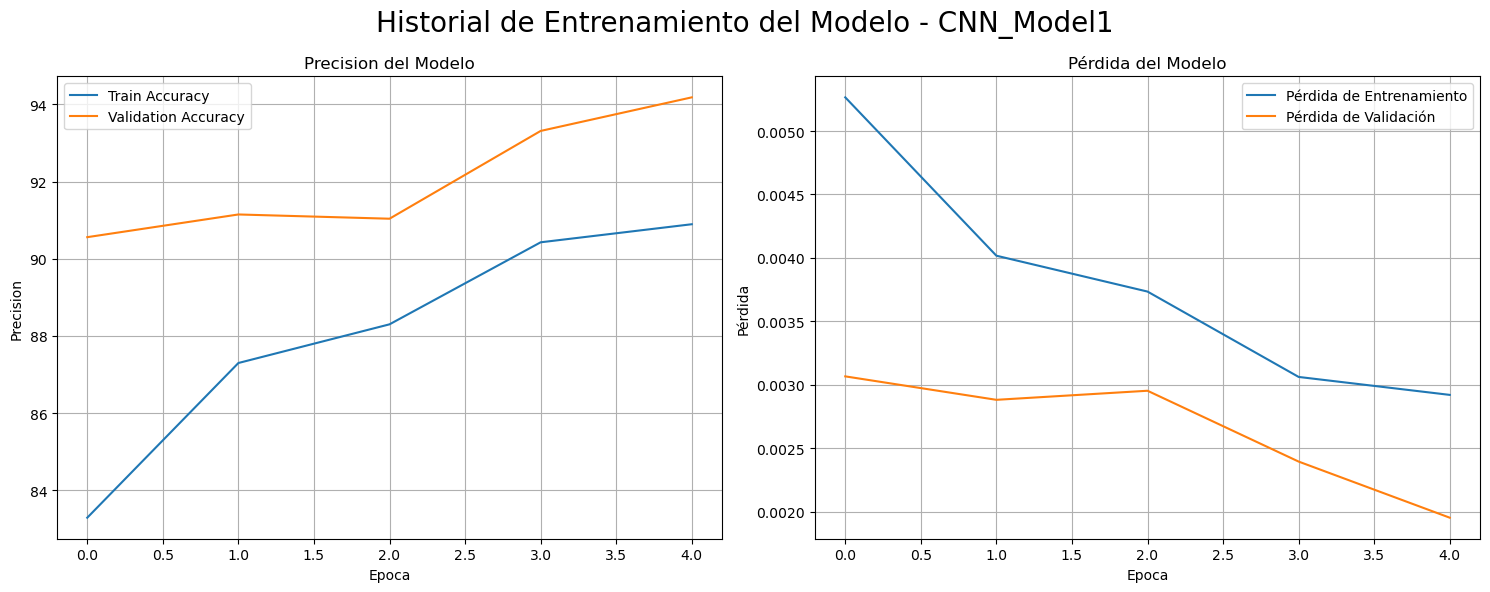

In [40]:
plot_history(train_loss, val_loss, train_accuracy, val_accuracy,'CNN_Model1')

#### Predicciones y Matriz de Confusion del Modelo

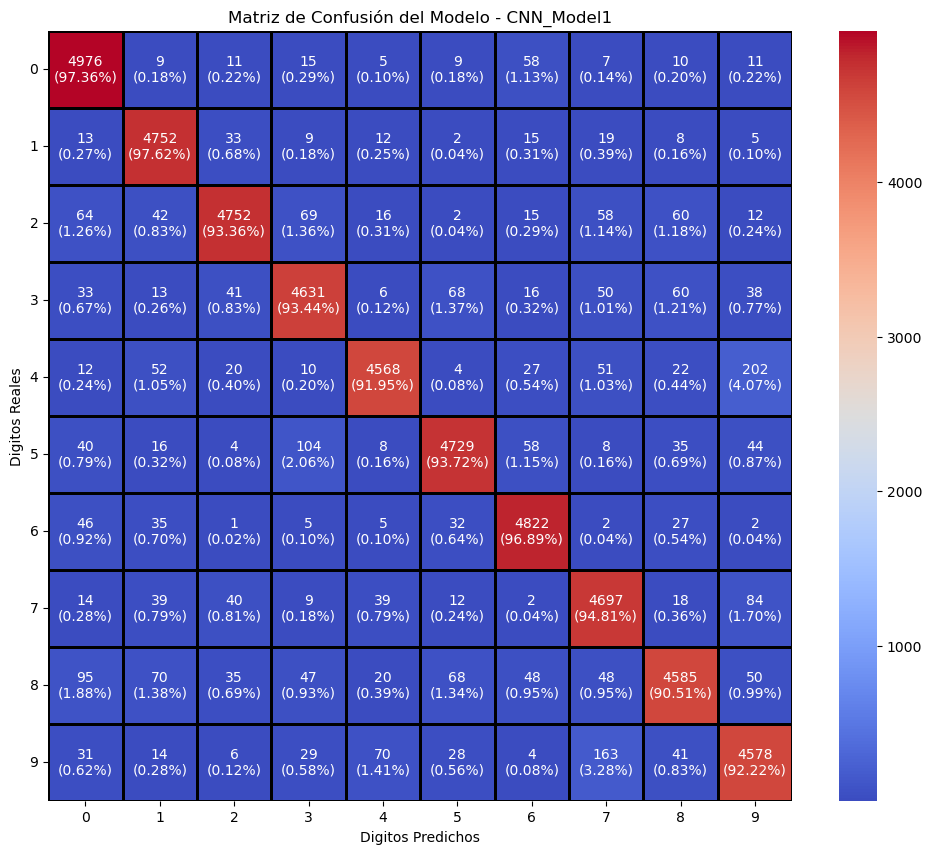

In [41]:
plot_confusion_matrix(y_val, val_preds, epochs, 'CNN_Model1')

#### Muestreo de Predicciones del Modelo

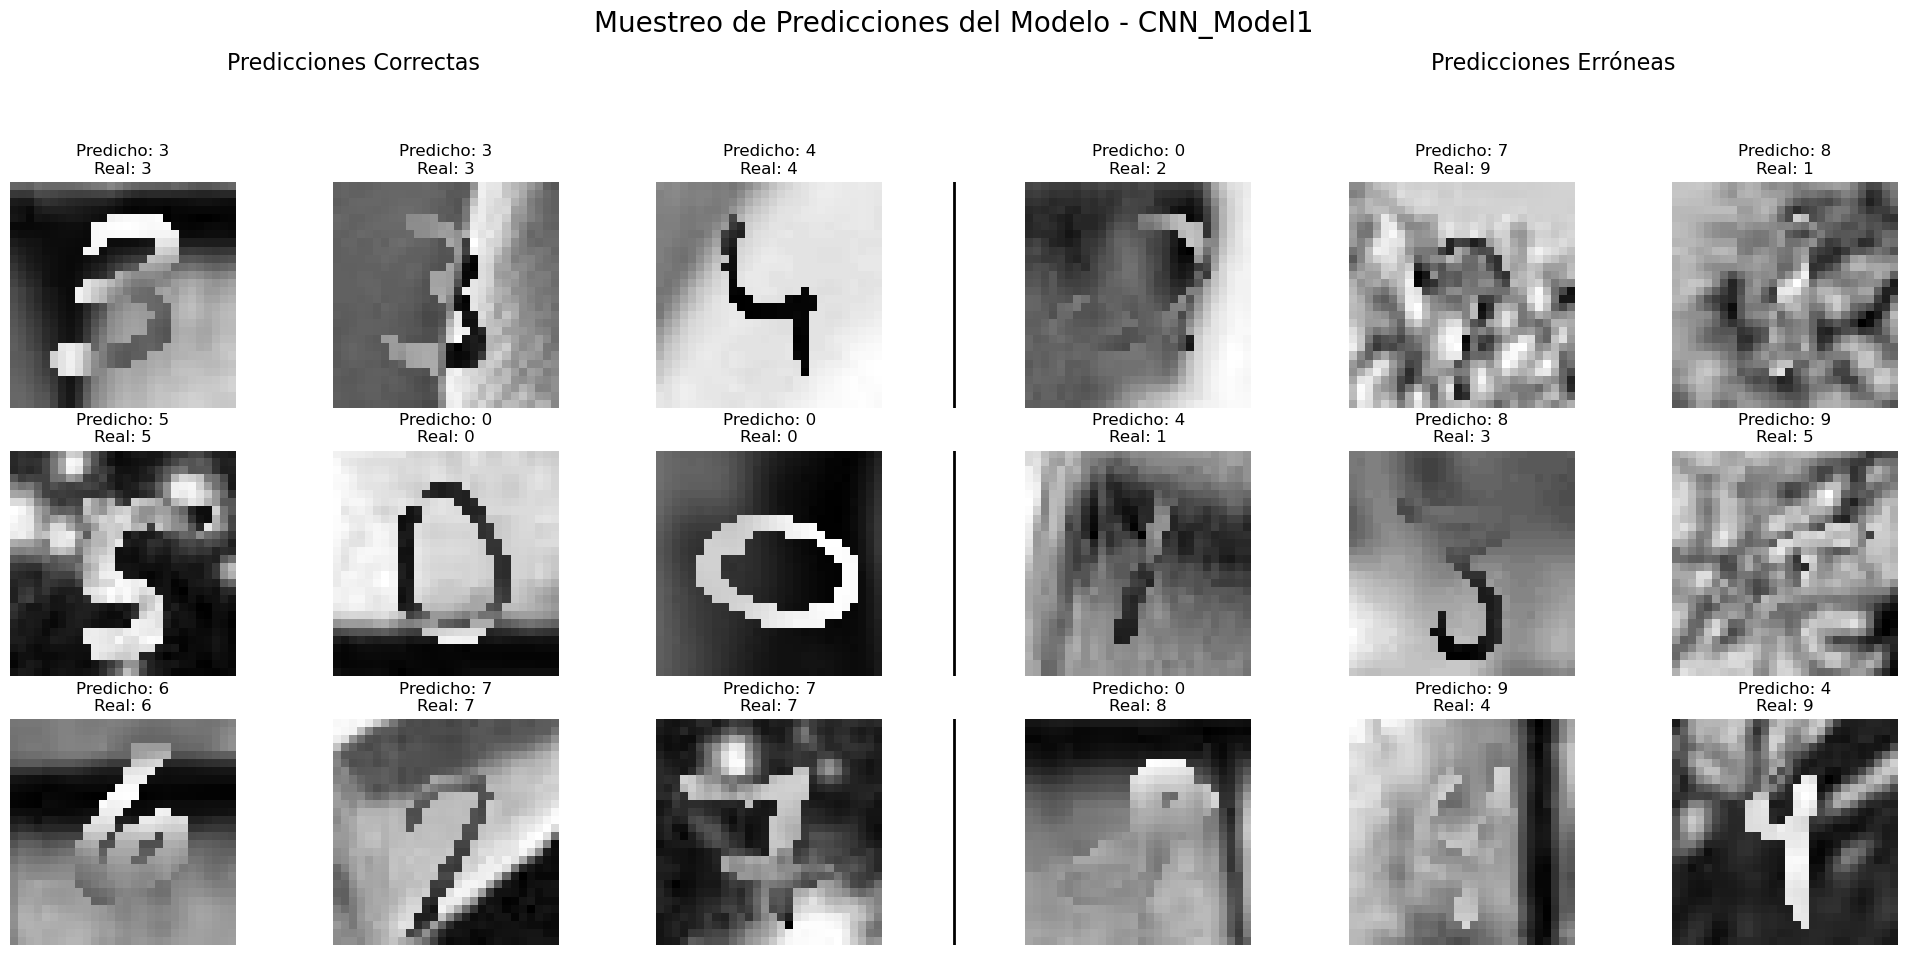

In [42]:
plot_predictions_sample(val_preds, y_val, X_val, epochs, 'CNN_Model1')